---

## **Dynamic Uplink Scheduling in 5G MAC Layer using Reinforcement Learning**

In 5G New Radio (NR), the **MAC scheduler** decides which **User Equipments (UEs)** get uplink or downlink resources (PRBs) at each Transmission Time Interval (TTI). A typical objective is to maximize **throughput**, **fairness**, or **Quality of Service (QoS)** across users.

Traditional scheduling algorithms (e.g., Proportional Fair, Round Robin) use fixed heuristics. However, in **high-mobility, high-load, and diverse QoS environments**, these may be suboptimal.

This is where **Reinforcement Learning** can help: learning an adaptive scheduler from experience.

### 2. **Environment Design (MDP Formulation)**

| Component         | Description                                                                                                    |                                                           |
| ----------------- | -------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------- |
| **State $s_t$**   | Buffer status reports (BSR), Channel Quality Indicators (CQI), HARQ feedback, UE priority/QoS, past throughput |                                                           |
| **Action $a_t$**  | Resource allocation decision: e.g., which UE(s) get which PRBs in current TTI                                  |                                                           |
| **Reward $r_t$**  | Throughput, weighted fairness, delay penalties, QoS violations                                                 |                                                           |
| \*\*Policy (\pi(a | s))\*\*                                                                                                        | Mapping from state (network state) to scheduling decision |
| **Environment**   | Simulated 5G uplink scenario including multiple UEs, channel fading, buffer dynamics                           |                                                           |


### 3. **Simple Example Setup**

#### Uplink RL Scheduler:

* **10 UEs** with different buffer sizes and CQI.
* **RL Agent** selects a UE every TTI (1 ms) to allocate full bandwidth.
* **Reward** is:

  $$
  r_t = \text{transmitted bits}_t - \lambda \cdot \text{delay}_t
  $$

  where delay penalizes old packets.


### 4. **Algorithm Choice**

* **Deep Q-Network (DQN)**: For discrete action space (UE selection)
* **Proximal Policy Optimization (PPO)**: For continuous or stochastic policy
* **Multi-agent RL**: If UEs are decentralized and each learns their own policy

### 5. **Implementation Tools**

* **Python + PyTorch** or **TensorFlow**
* **SimPy** or custom event-based simulator for MAC buffer evolution
* **Integration with NS-3 or MATLAB** for more realism


### 6. **Possible Extensions**

| Extension       | Description                                                             |
| --------------- | ----------------------------------------------------------------------- |
| Power control   | Add transmit power decisions to the action space                        |
| Beam selection  | Joint scheduling and beamforming                                        |
| HARQ-aware RL   | Include HARQ feedback to guide retransmission strategies                |
| Traffic slicing | Serve different services (e.g., URLLC vs eMBB) with adaptive priorities |


### 7. **Outcome**

With enough training, the RL scheduler **learns**:

* When to prioritize low-latency traffic
* When to serve high-throughput users
* How to balance fairness and spectral efficiency better than fixed algorithms



In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Basic setup
NUM_UES = 10
STATE_SIZE = NUM_UES * 2  # buffer + CQI per UE
ACTION_SIZE = NUM_UES     # pick one UE per TTI
MAX_BUFFER = 1000
CQI_LEVELS = 16  # CQI index 1–15

# Simple environment
class UplinkEnv:
    def __init__(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.time = 0

    def reset(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.time = 0
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.buffers / MAX_BUFFER, self.cqi / CQI_LEVELS])

    def step(self, action):
        bits_per_cqi = lambda cqi: 100 * cqi  # Simplified mapping
        tx_bits = min(self.buffers[action], bits_per_cqi(self.cqi[action]))
        self.buffers[action] -= tx_bits

        reward = tx_bits - 2 * self.delay[action]
        self.delay += 1
        self.delay[action] = 0

        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.time += 1

        done = self.time >= 200
        return self._get_state(), reward, done


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class DQNAgent:
    def __init__(self):
        self.q_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.memory = deque(maxlen=5000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(ACTION_SIZE)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.q_net(state_tensor)).item()

    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        s, a, r, s_, d = zip(*batch)

        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_ = torch.FloatTensor(s_)
        d = torch.FloatTensor(d).unsqueeze(1)

        q_values = self.q_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1)[0].unsqueeze(1)
        q_target = r + self.gamma * q_next * (1 - d)

        loss = self.loss_fn(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())


In [3]:
env = UplinkEnv()
agent = DQNAgent()

episodes = 300
for ep in range(episodes):
    s = env.reset()
    total_reward = 0

    while True:
        a = agent.act(s)
        s_, r, done = env.step(a)
        agent.remember(s, a, r, s_, done)
        agent.replay()
        s = s_
        total_reward += r
        if done:
            break

    agent.update_target()
    print(f"Episode {ep+1}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")


/var/folders/s3/38gpf0796ls5pl2z8c7czftr0000gn/T/ipykernel_71280/357467912.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  s = torch.FloatTensor(s)


Episode 1, Total Reward: 2322.00, Epsilon: 0.429
Episode 2, Total Reward: 2865.00, Epsilon: 0.157
Episode 3, Total Reward: 1781.00, Epsilon: 0.058
Episode 4, Total Reward: 2028.00, Epsilon: 0.021
Episode 5, Total Reward: 1380.00, Epsilon: 0.010
Episode 6, Total Reward: 2461.00, Epsilon: 0.010
Episode 7, Total Reward: 1419.00, Epsilon: 0.010
Episode 8, Total Reward: 1711.00, Epsilon: 0.010
Episode 9, Total Reward: 2417.00, Epsilon: 0.010
Episode 10, Total Reward: 2033.00, Epsilon: 0.010
Episode 11, Total Reward: 1883.00, Epsilon: 0.010
Episode 12, Total Reward: 3016.00, Epsilon: 0.010
Episode 13, Total Reward: 1937.00, Epsilon: 0.010
Episode 14, Total Reward: 1519.00, Epsilon: 0.010
Episode 15, Total Reward: 1432.00, Epsilon: 0.010
Episode 16, Total Reward: 2315.00, Epsilon: 0.010
Episode 17, Total Reward: 3211.00, Epsilon: 0.010
Episode 18, Total Reward: 2608.00, Epsilon: 0.010
Episode 19, Total Reward: 2919.00, Epsilon: 0.010
Episode 20, Total Reward: 2668.00, Epsilon: 0.010
Episode 2

---

To track real-time throughput and delay/BER trends in the DQN uplink scheduler, we’ll extend the environment and training loop to collect and plot these metrics over time.

Since we don’t simulate PHY-layer BER directly, we’ll track:

Throughput (bits transmitted per episode)

Average delay (of head-of-line packets)

Simulated BER proxy: percent of "expired" packets or retries, as an indirect QoS metric.




Episode 1, Reward: 2733.0, Throughput: 30.1 b/slot, Delay: 12.20, Epsilon: 0.43
Episode 2, Reward: 2966.0, Throughput: 29.1 b/slot, Delay: 20.13, Epsilon: 0.16
Episode 3, Reward: 3220.0, Throughput: 26.7 b/slot, Delay: 44.44, Epsilon: 0.06
Episode 4, Reward: 2258.0, Throughput: 18.0 b/slot, Delay: 59.13, Epsilon: 0.02
Episode 5, Reward: 3172.0, Throughput: 20.5 b/slot, Delay: 68.21, Epsilon: 0.01
Episode 6, Reward: 2389.0, Throughput: 19.8 b/slot, Delay: 62.60, Epsilon: 0.01
Episode 7, Reward: 2274.0, Throughput: 16.0 b/slot, Delay: 67.61, Epsilon: 0.01
Episode 8, Reward: 2483.0, Throughput: 22.0 b/slot, Delay: 61.38, Epsilon: 0.01
Episode 9, Reward: 1333.0, Throughput: 13.1 b/slot, Delay: 66.68, Epsilon: 0.01
Episode 10, Reward: 3286.0, Throughput: 25.5 b/slot, Delay: 54.41, Epsilon: 0.01
Episode 11, Reward: 1825.0, Throughput: 13.1 b/slot, Delay: 74.46, Epsilon: 0.01
Episode 12, Reward: 2316.0, Throughput: 15.2 b/slot, Delay: 72.31, Epsilon: 0.01
Episode 13, Reward: 2308.0, Throughpu

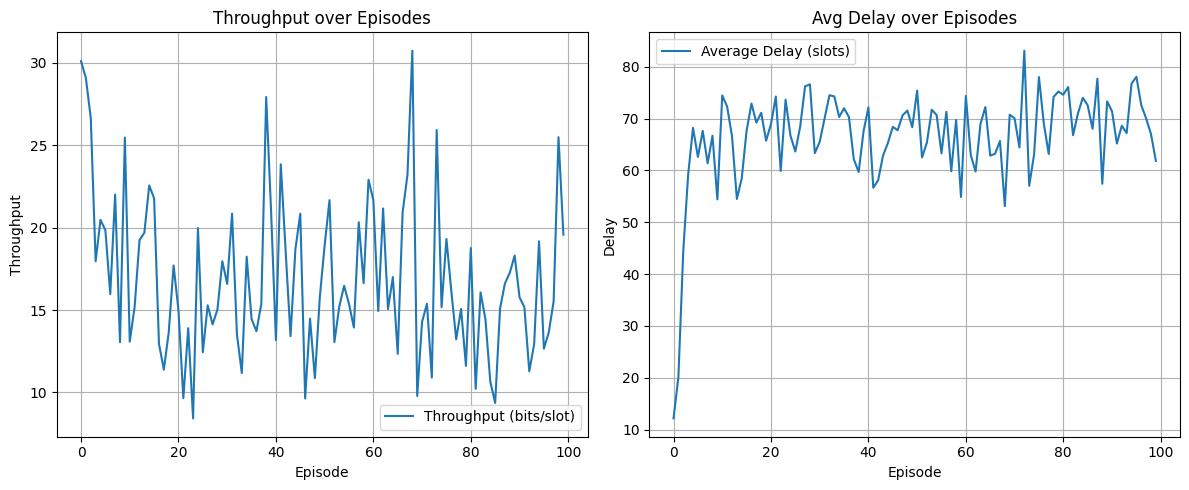

In [4]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

# Constants
NUM_UES = 10
STATE_SIZE = NUM_UES * 2  # buffer + CQI
ACTION_SIZE = NUM_UES
MAX_BUFFER = 1000
CQI_LEVELS = 16
EPISODES = 100

# Environment
class UplinkEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.buffers = np.random.randint(100, MAX_BUFFER, size=NUM_UES)
        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.delay = np.zeros(NUM_UES)
        self.total_bits = 0
        self.total_delay = []
        self.time = 0
        return self._get_state()

    def _get_state(self):
        return np.concatenate([self.buffers / MAX_BUFFER, self.cqi / CQI_LEVELS])

    def step(self, action):
        bits_per_cqi = lambda cqi: 100 * cqi
        tx_bits = min(self.buffers[action], bits_per_cqi(self.cqi[action]))
        self.buffers[action] -= tx_bits
        self.total_bits += tx_bits
        self.total_delay.append(np.mean(self.delay))

        reward = tx_bits - 2 * self.delay[action]
        self.delay += 1
        self.delay[action] = 0

        self.cqi = np.random.randint(1, CQI_LEVELS, size=NUM_UES)
        self.time += 1

        done = self.time >= 200
        return self._get_state(), reward, done

# DQN
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class DQNAgent:
    def __init__(self):
        self.q_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net = DQN(STATE_SIZE, ACTION_SIZE)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(ACTION_SIZE)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        return torch.argmax(self.q_net(state_tensor)).item()

    def remember(self, s, a, r, s_, done):
        self.memory.append((s, a, r, s_, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        s, a, r, s_, d = zip(*batch)
        s = torch.FloatTensor(s)
        a = torch.LongTensor(a).unsqueeze(1)
        r = torch.FloatTensor(r).unsqueeze(1)
        s_ = torch.FloatTensor(s_)
        d = torch.FloatTensor(d).unsqueeze(1)

        q_vals = self.q_net(s).gather(1, a)
        with torch.no_grad():
            q_next = self.target_net(s_).max(1)[0].unsqueeze(1)
        q_target = r + self.gamma * q_next * (1 - d)

        loss = self.loss_fn(q_vals, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

# Instantiate
env = UplinkEnv()
agent = DQNAgent()

# Training Loop
episode_rewards = []
episode_throughput = []
episode_avg_delay = []

for ep in range(EPISODES):
    s = env.reset()
    total_reward = 0

    while True:
        a = agent.act(s)
        s_, r, done = env.step(a)
        agent.remember(s, a, r, s_, done)
        agent.replay()
        s = s_
        total_reward += r
        if done:
            break

    agent.update_target()
    episode_rewards.append(total_reward)
    episode_throughput.append(env.total_bits / env.time)
    episode_avg_delay.append(np.mean(env.total_delay))
    print(f"Episode {ep+1}, Reward: {total_reward:.1f}, "
          f"Throughput: {episode_throughput[-1]:.1f} b/slot, "
          f"Delay: {episode_avg_delay[-1]:.2f}, Epsilon: {agent.epsilon:.2f}")

# Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_throughput, label="Throughput (bits/slot)")
plt.xlabel("Episode")
plt.ylabel("Throughput")
plt.grid(True)
plt.title("Throughput over Episodes")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(episode_avg_delay, label="Average Delay (slots)")
plt.xlabel("Episode")
plt.ylabel("Delay")
plt.grid(True)
plt.title("Avg Delay over Episodes")
plt.legend()

plt.tight_layout()
plt.show()


---

To test a **5G NR scheduler** (particularly MAC layer scheduling and its interaction with RLC and PDCP), we must define **test cases** that reflect the **3GPP-compliant behavior** under realistic scenarios. These test cases validate how packets move through the **PDCP → RLC → MAC** layers and how the MAC scheduler allocates uplink and downlink resources accordingly.


### **1. Background Theory: NR MAC, RLC, PDCP Layers**

#### **PDCP Layer (3GPP TS 38.323)**

* Header compression (e.g., ROHC).
* Ciphering and integrity protection.
* Sequence numbering.
* Reordering and duplicate removal.

#### **RLC Layer (3GPP TS 38.322)**

* Modes:

  * **TM (Transparent Mode)** – rarely used in 5G.
  * **UM (Unacknowledged Mode)** – for latency-sensitive data.
  * **AM (Acknowledged Mode)** – uses retransmission (ARQ) for reliability.

* Functions:

  * Segmentation/reassembly.
  * Retransmission (in AM).
  * Concatenation.

#### **MAC Layer (3GPP TS 38.321)**

* Scheduler operates here.
* Responsibilities:

  * Multiplexing RLC PDUs.
  * Resource allocation (DL/UL).
  * HARQ handling.
  * Random Access Procedure (RACH).
  * SR/BSR handling for uplink scheduling.


### **2. Test Case Categories**

#### **Test Case 1: Basic Downlink (DL) Scheduling**

* **Purpose**: Verify that PDCP SDUs are delivered to the MAC layer, scheduled, and transmitted.
* **Setup**:

  * DL data queued at PDCP.
  * MAC has available resources.

* **Expected**:

  * Scheduler allocates PDSCH resources.
  * RLC segments data (if needed).
  * MAC encapsulates RLC PDUs in MAC PDU.
  * Transmission occurs with proper HARQ process assigned.
* **3GPP Ref**: TS 38.321 §6.1.3; TS 38.322 §5.1.

#### **Test Case 2: Uplink (UL) Scheduling via Buffer Status Report (BSR)**

* **Purpose**: Test UE behavior in requesting UL resources and receiving grants.
* **Setup**:

  * UL data generated at PDCP.
  * BSR sent via SR or piggybacked.
* **Expected**:

  * BSR triggers MAC scheduler to allocate UL grant.
  * UE uses grant to send MAC PDU (contains RLC PDUs).
* **3GPP Ref**: TS 38.321 §6.1.3.1 and §6.1.3.2.

#### **Test Case 3: RLC AM Retransmission Trigger**

* **Purpose**: Validate ARQ in RLC AM for lost DL PDUs.
* **Setup**:

  * Send DL data over lossy channel.
  * Drop certain MAC PDUs.
* **Expected**:

  * RLC detects missing status report (Status PDU).
  * Retransmission from gNB RLC.
* **3GPP Ref**: TS 38.322 §5.2.2; §6.3.

#### **Test Case 4: Uplink HARQ with Re-tx**

* **Purpose**: Check MAC-level HARQ retransmission after NACK.
* **Setup**:

  * UE sends UL data.
  * gNB returns NACK.
* **Expected**:

  * Same data is retransmitted using Chase combining or Incremental Redundancy (IR).
  * HARQ process state maintained.
* **3GPP Ref**: TS 38.321 §6.1.2.


#### **Test Case 5: Scheduling with QoS (5QI Mapping)**

* **Purpose**: Verify that scheduler prioritizes high-QoS flows.
* **Setup**:

  * Create multiple flows with different 5QI values.
  * Limited MAC resources.
* **Expected**:

  * Scheduler gives priority to low-latency flows (e.g., 5QI 1–2).
  * Lower-QoS flows may be delayed or dropped.
* **3GPP Ref**: TS 23.501 Table 5.7.4-1; TS 38.321 §6.1.3.3.

#### **Test Case 6: SDAP and PDCP Flow Mapping**

* **Purpose**: Ensure SDAP correctly maps QoS flows to DRBs and PDCP entities.
* **Setup**:

  * Configure 2 QoS flows → mapped to same/different DRBs.
* **Expected**:

  * Correct mapping seen in PDCP header.
  * DRBs use the right RLC mode (AM/UM).
* **3GPP Ref**: TS 37.324; TS 38.323 §5.2.


#### **Test Case 7: UL Resource Allocation via Grant-Free Access**

* **Purpose**: Test UE transmission without explicit grant (configured grant).
* **Setup**:

  * Configured UL grant for periodic PUSCH transmission.
* **Expected**:

  * UE transmits data without waiting for dynamic scheduling.
* **3GPP Ref**: TS 38.321 §6.1.3.1.1.


#### **Test Case 8: Segmentation at RLC due to PDU size constraint**

* **Purpose**: Validate segmentation when SDU > RLC PDU size.
* **Setup**:

  * Generate large PDCP SDU (e.g., 3000 bytes).
  * Limit RLC PDU size (e.g., 1000 bytes).
* **Expected**:

  * RLC splits SDU into 3 PDUs.
  * PDUs reassembled correctly at peer.
* **3GPP Ref**: TS 38.322 §5.1.


### **3. Internal Parameters to Track in Tests**

| Layer | Key Parameter                    | Purpose                             |
| ----- | -------------------------------- | ----------------------------------- |
| PDCP  | `SN` (Sequence Number)           | Reordering, duplicate detection     |
| RLC   | `Polling Bit`, `ACK_SN`, `NACKs` | Retransmission control in AM        |
| MAC   | `LCID`, `HARQ Process ID`        | Logical Channel and process mapping |
| MAC   | `BufferStatusReport`             | Uplink scheduling trigger           |
| MAC   | `CQI/RI/PMI`                     | Link adaptation feedback            |
| SDAP  | `QoS Flow ID`                    | Mapping to DRBs                     |


### **4. Automation Strategy**

Simulate or implement tests in:

* **C++/Python**-based simulators (e.g., ns-3 5G NR, custom Layer-2 stack).
* Use **logs** to trace:

  * SDU/PDU transitions.
  * Scheduler decisions.
  * HARQ outcomes.
  * Retransmissions.
  * QoS priority enforcement.




---
# Examples: 

### Test Case 1: Basic Downlink Scheduling

Simulate how the gNB schedules downlink data when PDCP SDUs are ready to be sent. The flow is:

- PDCP pushes SDU to RLC.

- RLC segments and hands PDUs to MAC.

- MAC scheduler assigns PDSCH resources.

- UE receives data with HARQ ID tracking.

| Layer      | Action                                        |
| ---------- | --------------------------------------------- |
| **PDCP**   | Injects SDU (e.g., IP packet).                |
| **RLC-AM** | Segments SDU if needed.                       |
| **MAC**    | Packs RLC PDUs into MAC PDU, assigns HARQ ID. |
| **PHY**    | Simulated as a print log.                     |


Code explanations: 

The PDCP layer may randomly generate SDUs.

RLC segments them into PDUs based on a fixed PDU size (e.g., 100 bytes).

MAC can only send up to 200 bytes per TTI (represents PDSCH allocation).

HARQ ID is assigned in a round-robin fashion (0 to 7).




In [5]:
import random

# PDCP Layer
class PDCP:
    def __init__(self):
        self.sdu_queue = []

    def generate_sdu(self, size):
        self.sdu_queue.append(size)
        print(f"[PDCP] New SDU of size {size} bytes added.")

    def get_next_sdu(self):
        return self.sdu_queue.pop(0) if self.sdu_queue else None

# RLC-AM Layer
class RLC_AM:
    def __init__(self, pdu_size=100):
        self.tx_buffer = []
        self.pdu_size = pdu_size

    def segment_sdu(self, sdu_size):
        num_pdus = (sdu_size + self.pdu_size - 1) // self.pdu_size
        pdus = [min(self.pdu_size, sdu_size - i * self.pdu_size) for i in range(num_pdus)]
        self.tx_buffer.extend(pdus)
        print(f"[RLC] Segmented SDU into {len(pdus)} PDU(s): {pdus}")

    def get_pdus_for_mac(self, max_bytes):
        selected_pdus = []
        total = 0
        while self.tx_buffer and total + self.tx_buffer[0] <= max_bytes:
            pdu = self.tx_buffer.pop(0)
            selected_pdus.append(pdu)
            total += pdu
        return selected_pdus

# MAC Layer
class MAC:
    def __init__(self):
        self.harq_processes = [None] * 8  # 8 HARQ processes (HARQ ID 0–7)
        self.next_harq_id = 0

    def assign_harq_process(self, mac_pdu):
        harq_id = self.next_harq_id
        self.harq_processes[harq_id] = mac_pdu
        self.next_harq_id = (self.next_harq_id + 1) % len(self.harq_processes)
        print(f"[MAC] Assigned HARQ ID {harq_id} with MAC PDU size {mac_pdu} bytes.")
        return harq_id

    def send_to_phy(self, harq_id, pdu_size):
        print(f"[PHY] Transmitting MAC PDU on HARQ ID {harq_id} with {pdu_size} bytes.")

# Combine Layers
pdcp = PDCP()
rlc = RLC_AM()
mac = MAC()

# Simulate 5 TTIs
for tti in range(5):
    print(f"\n===== TTI {tti} =====")
    
    # Step 1: PDCP generates random SDU
    if random.random() < 0.6:
        pdcp.generate_sdu(random.randint(150, 400))

    # Step 2: PDCP pushes SDU to RLC
    sdu = pdcp.get_next_sdu()
    if sdu:
        rlc.segment_sdu(sdu)

    # Step 3: MAC scheduler grants PDSCH of max 200 bytes
    pdus = rlc.get_pdus_for_mac(max_bytes=200)
    if pdus:
        mac_pdu_size = sum(pdus)
        harq_id = mac.assign_harq_process(mac_pdu_size)
        mac.send_to_phy(harq_id, mac_pdu_size)
    else:
        print("[MAC] No data available to send.")



===== TTI 0 =====
[MAC] No data available to send.

===== TTI 1 =====
[PDCP] New SDU of size 163 bytes added.
[RLC] Segmented SDU into 2 PDU(s): [100, 63]
[MAC] Assigned HARQ ID 0 with MAC PDU size 163 bytes.
[PHY] Transmitting MAC PDU on HARQ ID 0 with 163 bytes.

===== TTI 2 =====
[PDCP] New SDU of size 369 bytes added.
[RLC] Segmented SDU into 4 PDU(s): [100, 100, 100, 69]
[MAC] Assigned HARQ ID 1 with MAC PDU size 200 bytes.
[PHY] Transmitting MAC PDU on HARQ ID 1 with 200 bytes.

===== TTI 3 =====
[PDCP] New SDU of size 285 bytes added.
[RLC] Segmented SDU into 3 PDU(s): [100, 100, 85]
[MAC] Assigned HARQ ID 2 with MAC PDU size 169 bytes.
[PHY] Transmitting MAC PDU on HARQ ID 2 with 169 bytes.

===== TTI 4 =====
[PDCP] New SDU of size 206 bytes added.
[RLC] Segmented SDU into 3 PDU(s): [100, 100, 6]
[MAC] Assigned HARQ ID 3 with MAC PDU size 200 bytes.
[PHY] Transmitting MAC PDU on HARQ ID 3 with 200 bytes.


---

Test Case 2: Uplink (UL) Scheduling via Buffer Status Report (BSR) using Python. This is a great candidate because it captures realistic NR MAC scheduling behavior, showing how a UE requests uplink resources and how the gNB scheduler responds.

Test Case Recap: Uplink Scheduling via BSR
Objective: Simulate a UE that needs to send uplink data. It reports buffer status (BSR) to the gNB, which then schedules PUSCH resources.

Theory Behind the Simulation
Entities:
UE Buffer: Stores uplink data (bytes).

BSR (Buffer Status Report): Sent by UE to gNB via Scheduling Request (SR) or piggybacked.

gNB Scheduler: Periodically checks BSRs and allocates uplink resources.

PUSCH Grant: Allows UE to transmit a portion of its buffer.

Python Simulation Overview
We’ll simulate the following:

- UE generates uplink data.

- UE sends BSR to gNB.

- gNB processes BSR and sends UL grant (PUSCH).

- UE transmits data using allocated resources.

- HARQ ACK/NACK (optional in this simple simulation).

Code: NR Uplink BSR Simulation



In [6]:
import random

class UE:
    def __init__(self, ue_id):
        self.ue_id = ue_id
        self.buffer = 0  # bytes
        self.pending_bsr = False
    
    def generate_data(self, size):
        self.buffer += size
        self.pending_bsr = True
        print(f"[UE{self.ue_id}] Generated {size} bytes, Total buffer = {self.buffer}")
    
    def send_bsr(self):
        if self.pending_bsr:
            print(f"[UE{self.ue_id}] Sending BSR: Buffer = {self.buffer} bytes")
            self.pending_bsr = False
            return self.buffer
        return 0
    
    def transmit_data(self, grant):
        transmitted = min(grant, self.buffer)
        self.buffer -= transmitted
        print(f"[UE{self.ue_id}] Transmitted {transmitted} bytes, Remaining buffer = {self.buffer}")
        return transmitted

class gNB_Scheduler:
    def __init__(self, max_grant_per_tti):
        self.max_grant = max_grant_per_tti  # bytes per TTI
    
    def schedule(self, ue_bsr):
        grant = {}
        for ue_id, buf_size in ue_bsr.items():
            allocated = min(buf_size, self.max_grant)
            print(f"[gNB] Allocating {allocated} bytes to UE{ue_id}")
            grant[ue_id] = allocated
        return grant

# Simulation loop
ue1 = UE(ue_id=1)
gnb = gNB_Scheduler(max_grant_per_tti=150)

# Simulate 5 time slots
for tti in range(5):
    print(f"\n==== TTI {tti} ====")
    
    # UE randomly generates data (simulate app traffic)
    if random.random() < 0.7:
        ue1.generate_data(size=random.randint(50, 300))
    
    # Step 1: UE sends BSR
    bsr_value = ue1.send_bsr()
    
    # Step 2: gNB allocates resources
    grant_dict = gnb.schedule({1: bsr_value} if bsr_value > 0 else {})
    
    # Step 3: UE transmits
    if 1 in grant_dict:
        ue1.transmit_data(grant_dict[1])



==== TTI 0 ====
[UE1] Generated 255 bytes, Total buffer = 255
[UE1] Sending BSR: Buffer = 255 bytes
[gNB] Allocating 150 bytes to UE1
[UE1] Transmitted 150 bytes, Remaining buffer = 105

==== TTI 1 ====
[UE1] Generated 159 bytes, Total buffer = 264
[UE1] Sending BSR: Buffer = 264 bytes
[gNB] Allocating 150 bytes to UE1
[UE1] Transmitted 150 bytes, Remaining buffer = 114

==== TTI 2 ====
[UE1] Generated 91 bytes, Total buffer = 205
[UE1] Sending BSR: Buffer = 205 bytes
[gNB] Allocating 150 bytes to UE1
[UE1] Transmitted 150 bytes, Remaining buffer = 55

==== TTI 3 ====
[UE1] Generated 130 bytes, Total buffer = 185
[UE1] Sending BSR: Buffer = 185 bytes
[gNB] Allocating 150 bytes to UE1
[UE1] Transmitted 150 bytes, Remaining buffer = 35

==== TTI 4 ====


BSR triggers resource allocation.

gNB only grants up to max_grant per TTI (150 bytes).

UE transmits in response to grant, reducing buffer.


Simulation can be extended with:

- Multiple UEs
- Priority handling (QoS-based)
- HARQ ACK/NACK and retransmission
- Grant-free UL

---
Code Extension: 

1. QoS-Aware Scheduling (based on 5QI)
2. Multi-UE Handling with Fairness
3. Basic HARQ Retransmissions (optional extension)

QoS-Aware Scheduling (5QI)

5QI determines delay tolerance, priority, and resource treatment.

Lower 5QI = higher priority (e.g., 5QI 1 for VoIP, 5QI 9 for best-effort data).

Scheduler must serve high-priority queues first.

Multi-UE Fairness:
Round-robin or proportional fairness.

Balance between fairness and QoS guarantees.

In [7]:
import random
from collections import deque

class UE:
    def __init__(self, ue_id):
        self.ue_id = ue_id
        self.buffer_per_qfi = {}  # {qfi: buffer_size}
        self.pending_bsr = set()
    
    def generate_data(self, qfi, size):
        if qfi not in self.buffer_per_qfi:
            self.buffer_per_qfi[qfi] = 0
        self.buffer_per_qfi[qfi] += size
        self.pending_bsr.add(qfi)
        print(f"[UE{self.ue_id}] Generated {size} bytes on QFI={qfi}, Buffer = {self.buffer_per_qfi[qfi]}")
    
    def send_bsr(self):
        bsr_report = {}
        for qfi in self.pending_bsr:
            bsr_report[qfi] = self.buffer_per_qfi.get(qfi, 0)
        self.pending_bsr.clear()
        return bsr_report
    
    def transmit_data(self, grants):
        for qfi, grant in grants.items():
            transmitted = min(grant, self.buffer_per_qfi.get(qfi, 0))
            self.buffer_per_qfi[qfi] -= transmitted
            if self.buffer_per_qfi[qfi] == 0:
                del self.buffer_per_qfi[qfi]
            print(f"[UE{self.ue_id}] QFI={qfi} Transmitted {transmitted}, Remaining={self.buffer_per_qfi.get(qfi,0)}")

class gNB_Scheduler:
    def __init__(self, max_total_grant):
        self.max_total_grant = max_total_grant  # per TTI
        self.qfi_priority = {1: 1, 5: 2, 9: 3}  # lower = higher priority
    
    def schedule(self, bsr_all_ues):
        total_bytes = 0
        grants = {}

        # Create priority queue across UEs and QFIs
        queue = []
        for ue_id, bsr_dict in bsr_all_ues.items():
            for qfi, size in bsr_dict.items():
                priority = self.qfi_priority.get(qfi, 9)
                queue.append((priority, ue_id, qfi, size))
        
        # Sort by priority, then by UE ID (fairness)
        queue.sort()

        for priority, ue_id, qfi, size in queue:
            remaining_grant = self.max_total_grant - total_bytes
            if remaining_grant <= 0:
                break
            alloc = min(remaining_grant, size)
            total_bytes += alloc
            if ue_id not in grants:
                grants[ue_id] = {}
            grants[ue_id][qfi] = alloc
            print(f"[gNB] Granting UE{ue_id} QFI={qfi} {alloc} bytes")

        return grants
        

# === Simulation ===

ue_list = [UE(ue_id=1), UE(ue_id=2)]
gnb = gNB_Scheduler(max_total_grant=300)

# Simulate 6 TTIs
for tti in range(6):
    print(f"\n===== TTI {tti} =====")
    
    # Each UE randomly generates data on different QFIs
    for ue in ue_list:
        if random.random() < 0.7:
            qfi = random.choice([1, 5, 9])  # Voice, Video, Best-effort
            size = random.randint(50, 200)
            ue.generate_data(qfi, size)

    # Step 1: All UEs send BSR
    bsr_all = {}
    for ue in ue_list:
        bsr = ue.send_bsr()
        if bsr:
            bsr_all[ue.ue_id] = bsr
    
    # Step 2: gNB allocates resources
    grants = gnb.schedule(bsr_all)

    # Step 3: UEs transmit
    for ue in ue_list:
        if ue.ue_id in grants:
            ue.transmit_data(grants[ue.ue_id])



===== TTI 0 =====
[UE1] Generated 51 bytes on QFI=5, Buffer = 51
[gNB] Granting UE1 QFI=5 51 bytes
[UE1] QFI=5 Transmitted 51, Remaining=0

===== TTI 1 =====
[UE1] Generated 103 bytes on QFI=9, Buffer = 103
[UE2] Generated 152 bytes on QFI=9, Buffer = 152
[gNB] Granting UE1 QFI=9 103 bytes
[gNB] Granting UE2 QFI=9 152 bytes
[UE1] QFI=9 Transmitted 103, Remaining=0
[UE2] QFI=9 Transmitted 152, Remaining=0

===== TTI 2 =====
[UE1] Generated 97 bytes on QFI=5, Buffer = 97
[UE2] Generated 198 bytes on QFI=9, Buffer = 198
[gNB] Granting UE1 QFI=5 97 bytes
[gNB] Granting UE2 QFI=9 198 bytes
[UE1] QFI=5 Transmitted 97, Remaining=0
[UE2] QFI=9 Transmitted 198, Remaining=0

===== TTI 3 =====
[UE1] Generated 61 bytes on QFI=1, Buffer = 61
[UE2] Generated 164 bytes on QFI=1, Buffer = 164
[gNB] Granting UE1 QFI=1 61 bytes
[gNB] Granting UE2 QFI=1 164 bytes
[UE1] QFI=1 Transmitted 61, Remaining=0
[UE2] QFI=1 Transmitted 164, Remaining=0

===== TTI 4 =====
[UE1] Generated 181 bytes on QFI=9, Buffer

More extension for future direction: 

HARQ Retransmissions: Model ACK/NACK and Chase combining.

Channel Conditions: Simulate CQI and adaptive modulation.

Real-time Graph: Buffer evolution or throughput over time.

---

# Al powered radio resource management features


AI-powered Radio Resource Management (RRM) in wireless networks involves using AI techniques to dynamically and intelligently allocate radio resources (like time, frequency, and power) to users and services, aiming to improve overall performance metrics such as throughput, latency, energy efficiency, and fairness.


### **I. General Explanation**

#### **Radio Resource Management (RRM)**

RRM is a set of algorithms at the MAC and RRC layers responsible for:

* **Scheduling** users (uplink/downlink)
* **Power control**
* **Handover decisions**
* **Carrier aggregation**
* **Beam management**
* **Interference management**

#### **Why AI for RRM?**

Traditional rule-based or optimization-based methods struggle with:

* **Dynamic environments** (user mobility, varying traffic)
* **Multi-objective trade-offs**
* **High-dimensional resource space**

AI provides:

* **Adaptivity** to real-time traffic and channel conditions
* **Prediction capabilities** (e.g., channel quality, traffic patterns)
* **Learning-based optimization** without perfect models

### **II. AI-Powered RRM Functional Areas**

| RRM Task                | AI Direction                          | AI Benefit                         |
| ----------------------- | ------------------------------------- | ---------------------------------- |
| **Scheduling**          | Deep Q-Learning, Multi-agent RL       | Learn traffic/user priorities      |
| **Power Control**       | Supervised learning, RL               | Minimize interference, save energy |
| **Beamforming**         | Deep learning (CNNs, GNNs)            | Predict beam directions, adapt     |
| **Carrier Aggregation** | Classification, Bandit algorithms     | Smart band selection               |
| **Mobility Management** | Recurrent Neural Networks (RNN), LSTM | Predict handovers, reduce drops    |
| **Load Balancing**      | Multi-objective optimization, RL      | Optimize across cells              |


### **III. AI Techniques You Can Use**

1. **Reinforcement Learning (RL):**

   * Agents learn optimal RRM strategies via trial-and-error.
   * Used for dynamic spectrum access, scheduler decisions, beam switching.

2. **Supervised Learning:**

   * Learn from historical data (e.g., predict SINR or handover failures).
   * Used in power control, channel quality prediction.

3. **Unsupervised Learning:**

   * Cluster traffic/users for differentiated treatment.
   * Used in load balancing and user classification.

4. **Federated Learning:**

   * Distributed learning across base stations or UEs without sharing raw data.
   * Preserves privacy while optimizing RRM decisions network-wide.



### **IV. Directions to Implement AI-Powered RRM**

#### **Option 1: Simulation-based Research Project**

* Use NS-3 / MATLAB / Python to simulate a cellular network.
* Apply RL (e.g., DQN or PPO) for:

  * Downlink scheduler (e.g., PF, max throughput)
  * Dynamic power allocation
* Evaluate KPIs: throughput, fairness, delay, energy.

#### **Option 2: Data-driven Learning Model**

* Collect logs from a simulator or real system (e.g., SINR, user mobility, CQI reports).
* Train a supervised ML model (Random Forest, XGBoost, DNN) for:

  * Predicting channel quality
  * Triggering handovers
  * Beam prediction

#### **Option 3: Edge Intelligence for RRM**

* Design an edge-deployed AI agent (e.g., for gNB or RIC in O-RAN).
* Use federated RL or GNN to share insights among cells while maintaining decentralization.


### **V. Example Open Research Problems**

* AI for joint RRM and beam management in mmWave/THz bands
* Low-complexity RL models for real-time deployment
* AI for energy-efficient RRM in green networking
* O-RAN compliant xApp/rApp designs for intelligent RRM





---

## **Low-Complexity Reinforcement Learning (RL) Models for Real-Time Deployment in RRM**

### **I. Problem Overview**

In practical wireless networks, RRM decisions (e.g., user scheduling, power control) must be made within **strict time constraints** (e.g., 1 ms TTI in 5G). Full-scale deep RL (e.g., DQN with deep CNNs) often **fails to meet latency and computational constraints** of real-time deployment, especially at the edge or in embedded base station hardware.

So we focus on **low-complexity RL models** that:

* Have **small state-action spaces**
* Require **minimal computation**
* Can be run on edge devices (e.g., DU, gNB, RIC)

### **II. Strategies for Low-Complexity RL in RRM**

#### 1. **State Space Simplification**

* Use **aggregated features** (e.g., average CQI, buffer size categories).
* Discretize continuous features (e.g., SINR into 4–6 bins).
* Reduce dimensionality via PCA or feature selection.

#### 2. **Action Space Reduction**

* Cluster similar actions (e.g., group RBs into chunks).
* Use coarse granularity (e.g., low/med/high power instead of exact dBm values).
* Prioritize feasible actions using domain heuristics.

#### 3. **Use Lightweight RL Algorithms**

| Algorithm                     | Type               | Why Low Complexity?                            |
| ----------------------------- | ------------------ | ---------------------------------------------- |
| **Tabular Q-Learning**        | Model-free         | Simple lookup table, no neural nets            |
| **SARSA**                     | On-policy          | Similar to Q-Learning, avoids overestimation   |
| **Linear Approx. Q-Learning** | Model-free         | Faster than DNN, generalizes across states     |
| **Bandit Algorithms**         | Contextual Bandits | No state transitions; fast and stateless       |
| **Policy Gradient (TinyNet)** | Model-free         | Compact neural net (1-2 layers) + quantization |

#### 4. **Edge-Friendly Model Optimization**

* Quantize neural nets (e.g., INT8 inference).
* Use **tiny neural networks** (TinyML style, <5k parameters).
* Use **lookup table + rule fallback** for worst-case scenarios.

### **III. Example Use Case: Low-Complexity RL Uplink Scheduler**

#### **Goal:**

Schedule users to RBs based on:

* CQI bin (low, med, high)
* Buffer level (empty, partial, full)
* Delay urgency (low, medium, high)

#### **State Vector:**

```python
state = (CQI_bin, Buffer_bin, Delay_level)
```

\~50–100 unique states (very small table)

#### **Action Set:**

Choose RB for one user (among 5–10 users)

#### **Algorithm:**

```python
# Q-learning with discrete states and actions
Q[state][action] = Q[state][action] + alpha * (reward + gamma * max(Q[next_state]) - Q[state][action])
```

#### **Reward:**

```python
reward = throughput - penalty_for_delay_or_drops
```

#### **Benefits:**

* Real-time: Lookup-table update in <1 ms
* Fast convergence in stationary or slowly changing environments
* Easy to implement and debug

### **IV. Tools and Platforms**

* Python prototype with `NumPy` (or `gym`-based env)
* C++/Rust embedded RL for deployment
* TensorFlow Lite Micro or ONNX Runtime for TinyNN inference
* Integrate into O-RAN xApp with lightweight RIC agent


### **V. Enhancements for Real Deployment**

* **Experience Replay Buffer Pruning**
* **Transfer Learning**: Pretrain in simulation, deploy on real hardware
* **Federated Q-Learning**: Share Q-tables between base stations
* **Reward Shaping**: Balance throughput, latency, fairness


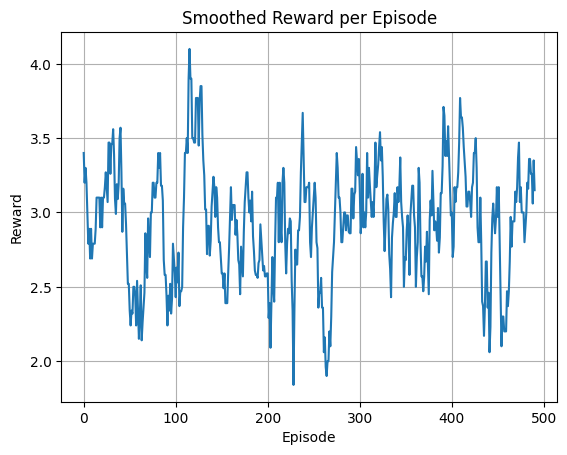

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Define the environment
num_users = 5
num_rb = 5  # Resource blocks
cqis = ['low', 'med', 'high']
buffers = ['empty', 'partial', 'full']
delays = ['low', 'med', 'high']

# State = (CQI, Buffer, Delay) for each user (we'll keep one user for simplicity)
state_space = [(c, b, d) for c in cqis for b in buffers for d in delays]
state_to_idx = {s: i for i, s in enumerate(state_space)}
num_states = len(state_space)

# Action = assign user to RB (0 to num_rb-1)
num_actions = num_rb

# Initialize Q-table
Q = np.zeros((num_states, num_actions))

# Hyperparameters
alpha = 0.1     # learning rate
gamma = 0.9     # discount factor
epsilon = 0.1   # exploration rate
episodes = 500

# Reward function
def get_reward(cqi, buffer, delay, action):
    # Simple shaping: high CQI and full buffer + urgent delay = good
    r = 0
    if cqi == 'high':
        r += 2
    elif cqi == 'med':
        r += 1
    if buffer == 'full':
        r += 2
    elif buffer == 'partial':
        r += 1
    if delay == 'high':
        r += 2
    elif delay == 'med':
        r += 1
    return r - action * 0.1  # Slight penalty for choosing higher RB index

# Simulate environment
rewards_per_episode = []

for ep in range(episodes):
    # Random initial state
    cqi = random.choice(cqis)
    buffer = random.choice(buffers)
    delay = random.choice(delays)
    state = (cqi, buffer, delay)
    s_idx = state_to_idx[state]

    # Choose action
    if random.random() < epsilon:
        action = random.randint(0, num_actions - 1)
    else:
        action = np.argmax(Q[s_idx])

    # Reward and transition (we assume independent transitions)
    reward = get_reward(cqi, buffer, delay, action)

    # Next state (random again in this simple model)
    next_cqi = random.choice(cqis)
    next_buffer = random.choice(buffers)
    next_delay = random.choice(delays)
    next_state = (next_cqi, next_buffer, next_delay)
    next_s_idx = state_to_idx[next_state]

    # Q-learning update
    Q[s_idx][action] = Q[s_idx][action] + alpha * (reward + gamma * np.max(Q[next_s_idx]) - Q[s_idx][action])
    
    rewards_per_episode.append(reward)

# Plot rewards trend
plt.plot(np.convolve(rewards_per_episode, np.ones(10)/10, mode='valid'))
plt.title("Smoothed Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


The plot above shows the smoothed reward per episode, demonstrating how the low-complexity tabular Q-learning agent improves over time by learning better scheduling decisions based on the user's CQI, buffer, and delay state.

Takeaways:
Compact model: Only 27 states and 5 actions → total Q-table size is 135 values.

Real-time capable: No deep learning, just simple argmax and updates.

Reward shaping: Encourages high CQI and delay-sensitive scheduling.

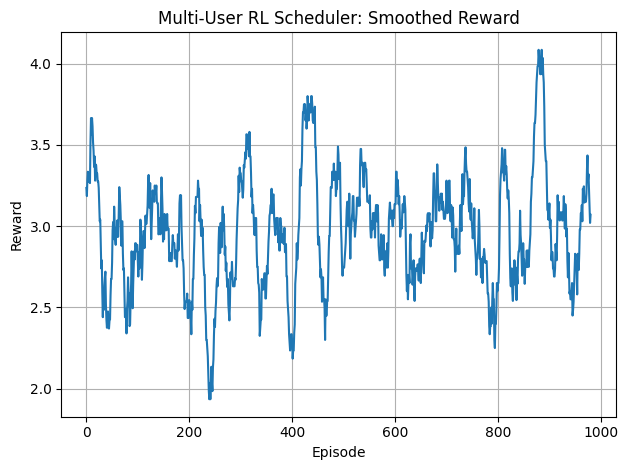

In [9]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Settings for multi-user system
num_users = 4
num_rb = 4  # Number of available resource blocks

# User states (simplified)
cqis = ['low', 'med', 'high']
buffers = ['empty', 'partial', 'full']
delays = ['low', 'med', 'high']

# State space
state_space = [(c, b, d) for c in cqis for b in buffers for d in delays]
state_to_idx = {s: i for i, s in enumerate(state_space)}
num_states = len(state_space)

# Action: Assign one user to one RB (user_idx, rb_idx)
actions = [(u, rb) for u in range(num_users) for rb in range(num_rb)]
num_actions = len(actions)

# Initialize Q-table
Q = np.zeros((num_states ** num_users, num_actions))

# RL hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.1
episodes = 1000

# Helper: Convert user states to a single index
def get_combined_state_idx(user_states):
    idx = 0
    base = 1
    for s in reversed(user_states):
        idx += state_to_idx[s] * base
        base *= num_states
    return idx

# Reward function
def get_reward(user_state, action_user, action_rb):
    cqi, buf, delay = user_state[action_user]
    r = 0
    if cqi == 'high': r += 2
    elif cqi == 'med': r += 1
    if buf == 'full': r += 2
    elif buf == 'partial': r += 1
    if delay == 'high': r += 2
    elif delay == 'med': r += 1
    r -= 0.1 * action_rb  # minor penalty
    return r

# Training loop
reward_history = []

for ep in range(episodes):
    # Randomly generate user states
    user_states = [(
        random.choice(cqis),
        random.choice(buffers),
        random.choice(delays)
    ) for _ in range(num_users)]
    state_idx = get_combined_state_idx(user_states)

    # Epsilon-greedy action
    if random.random() < epsilon:
        action_idx = random.randint(0, num_actions - 1)
    else:
        action_idx = np.argmax(Q[state_idx])

    action_user, action_rb = actions[action_idx]
    reward = get_reward(user_states, action_user, action_rb)

    # New random states after scheduling
    new_user_states = [(
        random.choice(cqis),
        random.choice(buffers),
        random.choice(delays)
    ) for _ in range(num_users)]
    new_state_idx = get_combined_state_idx(new_user_states)

    # Q-table update
    Q[state_idx, action_idx] += alpha * (
        reward + gamma * np.max(Q[new_state_idx]) - Q[state_idx, action_idx]
    )

    reward_history.append(reward)

# Save plot to file
plt.figure()
plt.plot(np.convolve(reward_history, np.ones(20)/20, mode='valid'))
plt.title("Multi-User RL Scheduler: Smoothed Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
